# You Lost - Effects of Mariginal Dissatisfaction on Election Outcomes

## 00 - ToDos

1. Add Texas
2. Idea: use early votes to come up with differences before and after the games. (However selection).
3. Do placebo tests in different years (prior to 2016)
4. Do placebo tests with game results following the election week

## 01 - Settings

### 1.1 Imports

In [513]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

### 1.2 Functions

In [252]:
# Functions

## 02 - Load and Clean Data

### 2.1 Panel Data of County Election Outcomes

In [555]:
# Data downloaded from: MIT Election Lab - https://electionlab.mit.edu/data

raw_elections = pd.read_excel('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/02_Data/County_Level/countypres_2000-2020.xlsx')

In [556]:
raw_elections

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


In [557]:
# Filter for only Democrat and Republican
raw_elections = raw_elections.loc[raw_elections['party'].isin(['DEMOCRAT', 'REPUBLICAN'])]

# Filter for only total results
raw_elections = raw_elections.loc[raw_elections['mode'].isin(['TOTAL'])]

# Filter for election years 2000-2016 (in 2020 some obs. for North Carolina are missing - why?)
raw_elections = raw_elections.loc[raw_elections['year'] != 2020]

In [558]:
raw_elections

,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
5,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,40872,56480,20220315,TOTAL
8,2000,ALABAMA,AL,BARBOUR,1005.0,US PRESIDENT,AL GORE,DEMOCRAT,5188,10395,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...
50516,2016,ALASKA,AK,DISTRICT 39,2039.0,US PRESIDENT,DONALD TRUMP,REPUBLICAN,1405,5639,20220315,TOTAL
50518,2016,ALASKA,AK,DISTRICT 40,2040.0,US PRESIDENT,HILLARY CLINTON,DEMOCRAT,2338,4610,20220315,TOTAL
50519,2016,ALASKA,AK,DISTRICT 40,2040.0,US PRESIDENT,DONALD TRUMP,REPUBLICAN,1377,4610,20220315,TOTAL
50521,2016,ALASKA,AK,DISTRICT 99,2099.0,US PRESIDENT,HILLARY CLINTON,DEMOCRAT,274,342,20220315,TOTAL


In [559]:
# See if there are two hits per county_fips per election year
raw_elections['county_fips'].value_counts().describe()

count    3156.000000
mean        9.996198
std         0.151018
min         2.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: county_fips, dtype: float64

In [560]:
# Okay, there is some data issue - most likely some of the Counties have been rearranged, so take a closer look.
# Issue resolved if only including 2000-2016 (which is what I am interested in anyways)
raw_elections = raw_elections.merge(raw_elections.groupby(['county_fips'])['county_fips'].count().reset_index(name="count"), left_on='county_fips', right_on='county_fips', how='left')

In [561]:
# Reshape the df to get the party results in the wide format
raw_elections = raw_elections.reset_index().pivot_table(index=['year', 'state', 'county_fips', 'county_name', 'office', 'version', 'totalvotes'], columns=['party'], values='candidatevotes', aggfunc='mean').reset_index()

In [562]:
# reset name of the index
raw_elections = raw_elections.rename_axis(None)

In [563]:
# create a total between democrats and republicans and calculate a percentage
raw_elections['Total'] = raw_elections['DEMOCRAT']+raw_elections['REPUBLICAN']
raw_elections['margin_democrat'] = raw_elections['DEMOCRAT']/raw_elections['Total']
raw_elections['margin_republican'] = raw_elections['REPUBLICAN']/raw_elections['Total']

In [564]:
raw_elections

party,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican
0,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178
1,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901
2,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527
3,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915
4,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921
...,...,...,...,...,...,...,...,...,...,...,...,...
15769,2016,WYOMING,56037.0,SWEETWATER,US PRESIDENT,20220315,17130,3231,12154,15385,0.210010,0.789990
15770,2016,WYOMING,56039.0,TETON,US PRESIDENT,20220315,12627,7314,3921,11235,0.651001,0.348999
15771,2016,WYOMING,56041.0,UINTA,US PRESIDENT,20220315,8470,1202,6154,7356,0.163404,0.836596
15772,2016,WYOMING,56043.0,WASHAKIE,US PRESIDENT,20220315,3814,532,2911,3443,0.154516,0.845484


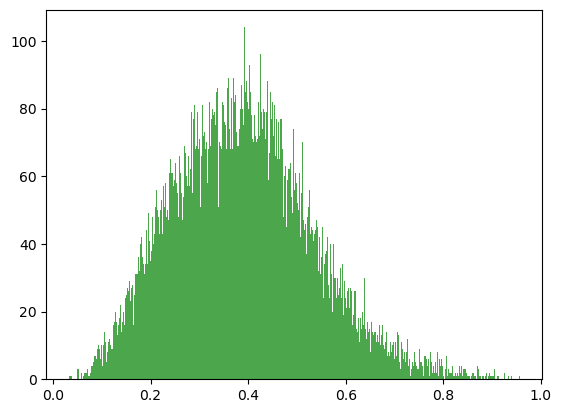

In [565]:
# Election outcome in US Counties (500 bins)

# create histogram
plt.hist(raw_elections['margin_democrat'], bins=500, color ='green', alpha = 0.7)

# display histogram
plt.show()

In [566]:
# Panel to work with (for now only condition on the following states: Florida, North Carolina, Texas)

panel = raw_elections.loc[raw_elections['state'].isin(['NORTH CAROLINA', 'TEXAS', 'FLORIDA', 'ALABAMA', 'GEORGIA', 'SOUTH CAROLINA', 'MISSISSIPPI', 'LOUISIANA'])]

In [567]:
# Datset of interest
panel

party,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican
0,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178
1,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901
2,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527
3,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915
4,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921
...,...,...,...,...,...,...,...,...,...,...,...,...
15403,2016,TEXAS,48499.0,WOOD,US PRESIDENT,20220315,18727,2630,15700,18330,0.143481,0.856519
15404,2016,TEXAS,48501.0,YOAKUM,US PRESIDENT,20220315,2303,426,1797,2223,0.191633,0.808367
15405,2016,TEXAS,48503.0,YOUNG,US PRESIDENT,20220315,7707,876,6601,7477,0.117159,0.882841
15406,2016,TEXAS,48505.0,ZAPATA,US PRESIDENT,20220315,3142,2063,1029,3092,0.667206,0.332794


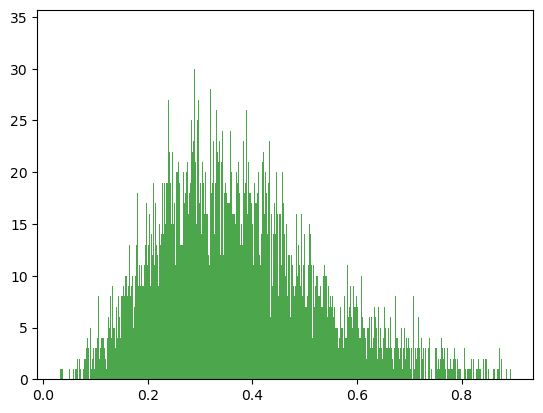

In [568]:
# Election outcome in US Counties (500 bins)

# create histogram
plt.hist(panel['margin_democrat'], bins=500, color ='green', alpha = 0.7)

# display histogram
plt.show()

Election outcomes are highly idiosyncratic. Hence, the marginal effect of loosing needs to be identified.

First of all, idiosyncratic voting behavior on the level of the county is filtered out, by running fixed effects regressions on the elections from 2000-2016 (in perspective including control variables on the county level, i.e. determinants along the lines of race, sex, employment, urban, etc.).

In a second step, the residuals from the fixed effects regression are regarded in a regression discontinuity design (RDD) for the year 2016 (year of interest) the RDD is performed. It is hypothezised that there is a sorty of residuals that leave explanatory power to the marginal impact of a loss. Because featuring a loosing / winning team may be endogenous to a certain degree, the marginal effect of a loss, i.e. being a winner vs. being a looser is identified through a RDD.

In [488]:
# Use this to view the data
panel.to_excel('elections_county_all_years.xlsx')

In [489]:
panel

party,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican
0,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178
1,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901
2,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527
3,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915
4,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921
...,...,...,...,...,...,...,...,...,...,...,...,...
15403,2016,TEXAS,48499.0,WOOD,US PRESIDENT,20220315,18727,2630,15700,18330,0.143481,0.856519
15404,2016,TEXAS,48501.0,YOAKUM,US PRESIDENT,20220315,2303,426,1797,2223,0.191633,0.808367
15405,2016,TEXAS,48503.0,YOUNG,US PRESIDENT,20220315,7707,876,6601,7477,0.117159,0.882841
15406,2016,TEXAS,48505.0,ZAPATA,US PRESIDENT,20220315,3142,2063,1029,3092,0.667206,0.332794


### 2.2 Football Prominence in Counties (FL, TX, NC, AL, LA, MS, GA, SC)

In [375]:
NCAA_fanbase = pd.DataFrame()

states = ['Florida', 'North Carolina', 'Texas', 'Alabama', 'Louisiana', 'Mississippi', 'Georgia', 'South Carolina']

for state in states:
    NCAA_fanbase_schlup = pd.read_excel('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/02_Data/NCAA_fanbase.xlsx', sheet_name=state)
    NCAA_fanbase = NCAA_fanbase.append(NCAA_fanbase_schlup)

C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1373836311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NCAA_fanbase = NCAA_fanbase.append(NCAA_fanbase_schlup)
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1373836311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NCAA_fanbase = NCAA_fanbase.append(NCAA_fanbase_schlup)
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1373836311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NCAA_fanbase = NCAA_fanbase.append(NCAA_fanbase_schlup)
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1373836311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NCAA_fanbase = NCAA_fanbase.append(N

In [376]:
NCAA_fanbase['state_county'] = NCAA_fanbase['State']+NCAA_fanbase['County']

In [377]:
NCAA_fanbase = NCAA_fanbase.merge(NCAA_fanbase.groupby('state_county')['Number'].sum().reset_index().rename(columns={'Number': 'total'}), how='left', on= 'state_county')


In [378]:
NCAA_fanbase['Percent'] = NCAA_fanbase['Number']/NCAA_fanbase['total']

In [379]:
# drop counties where the number of identified fans is lower than 20 (before 2079 obs)
#NCAA_fanbase = NCAA_fanbase.loc[NCAA_fanbase['total'] > 40]

# Adaptation: set counties with less than 40 Observations to NaN
#NCAA_fanbase['Percent'][NCAA_fanbase['total'] < 0] = np.nan

# afterwards: 2000 obs

In [380]:
NCAA_fanbase.to_excel('NCAA_fanbase_percent.xlsx')

In [381]:
NCAA_fanbase_sum = NCAA_fanbase.groupby(['Team'])['Number'].sum()

In [382]:
NCAA_fanbase_sum

Team
Abilene Christian       659.0
Akron                     1.0
Alabama              148112.1
Alabama A&M               2.0
Alabama State           517.0
                       ...   
Western Carolina        976.0
Wofford                 402.0
Yale                      4.0
Youngstown State         12.0
uab                      82.0
Name: Number, Length: 124, dtype: float64

In [383]:
# Calculate the most prominent team per county
#NCAA_fanbase = NCAA_fanbase.sort_values(['state_county', "Percent"], ascending=[True, False]).groupby('state_county').first().reset_index()

In [384]:
#NCAA_fanbase['Inverse'] = 1/NCAA_fanbase['Percent']

In [385]:
NCAA_fanbase

,State,County,Total,Team,Number,%,state_county,total,Percent
0,Florida,Alachua,9689,Florida,8311.0,0.858,FloridaAlachua,9779.0,0.849882
1,Florida,Alachua,9689,Florida State,572.0,0.059,FloridaAlachua,9779.0,0.058493
2,Florida,Alachua,9689,Alabama,318.0,0.033,FloridaAlachua,9779.0,0.032519
3,Florida,Alachua,9689,UCF,313.0,0.032,FloridaAlachua,9779.0,0.032007
4,Florida,Alachua,9689,Georgia,265.0,0.027,FloridaAlachua,9779.0,0.027099
...,...,...,...,...,...,...,...,...,...
4158,South Carolina,Beaufort,2420,South Carolina,938.0,0.388,South CarolinaBeaufort,2036.0,0.460707
4159,South Carolina,Beaufort,2420,Clemson,571.0,0.236,South CarolinaBeaufort,2036.0,0.280452
4160,South Carolina,Beaufort,2420,Georgia,241.0,0.100,South CarolinaBeaufort,2036.0,0.118369
4161,South Carolina,Beaufort,2420,Alabama,166.0,0.069,South CarolinaBeaufort,2036.0,0.081532


This is now ready to be merged to the election outcome dataframe. One key assumption is that the share of fandom does not change over time. That is while the population might be growing etc. the preferred team in a given county stays the same.

Multiply the Inverse with the difference between the games. This is to account for the fact that the games might be differently viewed in the different counties.

In [386]:
# Extract list of all unique teams featured in the data above:

t = NCAA_fanbase['Team'].to_list()
list(set(t))

['Georgia Tech',
 'Campbell',
 'Jackson State',
 'North Carolina A&T',
 'South Florida',
 'Michigan',
 'Navy',
 'Northwestern State',
 'Auburn',
 'Lamar',
 'Tarleton State',
 'Bowling Green',
 'Eastern Michigan',
 'Ohio State',
 'Tulane',
 'West Virginia',
 'North Carolina',
 'Bryant',
 'LA Lafayette',
 'Coastal Carolina',
 'SMU',
 'Prairie View A&M',
 'Texas State',
 'Alabama State',
 'Baylor',
 'Abilene Christian',
 'Southern Miss',
 'LSU',
 'Texas Tech',
 'Miami',
 'Troy',
 'North Carolina State',
 'Mississippi State',
 'Yale',
 'Furman',
 'Georgia State',
 'Louisville',
 'Southeastern Louisiana',
 'Alcorn State',
 'Minnesota',
 'Presbyterian',
 'Florida International',
 'Alabama A&M',
 'Tennessee',
 'Oregon',
 'Clemson',
 'UCF',
 'New Mexiko State',
 'Stetson',
 'Bethune-Cookman',
 'UAB',
 'Old Dominion',
 'Citadel',
 'Kansas',
 'Grambling',
 'East Carolina',
 'Mercer',
 'Georgia',
 'Houston',
 'Sam Houston',
 'Elon',
 'Charleston Southern',
 'Arizona',
 'LA Tech',
 'UTEP',
 'Colum

### 2.3 NCAA Division 1 Football Election Week Game Results

In [389]:
game_results = pd.read_excel('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/02_Data/Game_Results.xlsx')

In [390]:
game_results

,id,season,week,season_type,start_date,start_time_tbd,completed,neutral_site,conference_game,attendance,...,away_line_scores[0],away_line_scores[1],away_line_scores[2],away_line_scores[3],away_post_win_prob,away_pregame_elo,away_postgame_elo,excitement_index,highlights,notes
0,400869320.0,2016.0,10.0,regular,2016-11-02T00:00:00.000Z,NaN,True,False,True,4790.0,...,7.0,6.0,7.0,0.0,0.000711,1162.0,1130.0,1.765067,NaN,NaN
1,400869321.0,2016.0,10.0,regular,2016-11-02T00:00:00.000Z,NaN,True,False,True,5614.0,...,21.0,7.0,14.0,10.0,0.994715,1817.0,1842.0,1.820388,NaN,NaN
2,400869322.0,2016.0,10.0,regular,2016-11-02T23:30:00.000Z,NaN,True,False,True,6559.0,...,3.0,17.0,14.0,14.0,0.972258,1661.0,1702.0,3.334578,NaN,NaN
3,400869323.0,2016.0,10.0,regular,2016-11-03T22:00:00.000Z,NaN,True,False,True,17113.0,...,0.0,10.0,0.0,0.0,0.000628,1142.0,1109.0,0.987528,NaN,NaN
4,400872497.0,2016.0,10.0,regular,2016-11-03T23:00:00.000Z,False,True,False,True,NaN,...,0.0,3.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,NaN,NaN,NaN,NaN,2023-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,2023-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,NaN,NaN,NaN,NaN,2023-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,NaN,NaN,NaN,NaN,2023-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
game_results['margin_home_team'] = game_results['home_points']-game_results['away_points']
game_results['margin_away_team'] = game_results['margin_home_team']*(-1)

In [392]:
# Create one df of results per team
game_results_match_home = game_results[['home_team', 'margin_home_team']].rename(columns={'home_team': 'team', 'margin_home_team': 'margin'})
game_results_match_away = game_results[['away_team', 'margin_away_team']].rename(columns={'away_team': 'team', 'margin_away_team': 'margin'})

In [393]:
game_results_match = game_results_match_home.append(game_results_match_away)

C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1686519004.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  game_results_match = game_results_match_home.append(game_results_match_away)


In [394]:
game_results_match['result'] = np.where(game_results_match['margin'] > 0, 1, (np.where(game_results_match['margin'] < 0, -1, np.nan)))

In [395]:
game_results_match

,team,margin,result
0,Northern Illinois,25.0,1.0
1,Ball State,-32.0,-1.0
2,Akron,-31.0,-1.0
3,Ohio,24.0,1.0
4,Nicholls,25.0,1.0
...,...,...,...
129,Central Arkansas,20.0,1.0
130,Midwestern State,5.0,1.0
131,Texas-Permian Basin,-37.0,-1.0
132,South Alabama,-14.0,-1.0


In [396]:
# Maybe think about this more closely
#game_results_match = game_results_match.dropna()

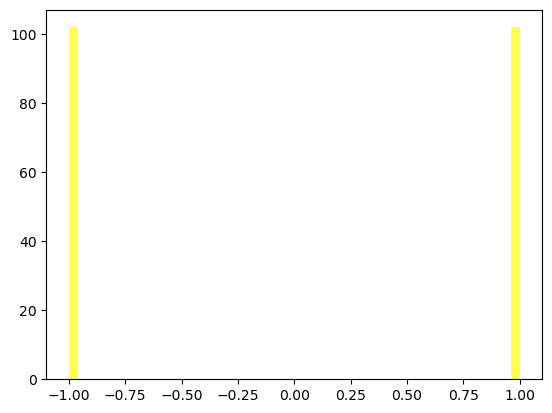

In [397]:
# Game Results, 50 bins

# create histogram
plt.hist(game_results_match[['result']], bins=50, color =['yellow'], alpha = 0.7)

# display histogram
plt.show()

In [398]:
# Recode North Carolina
game_results_match = game_results_match.replace(to_replace='NC State', value='North Carolina State')

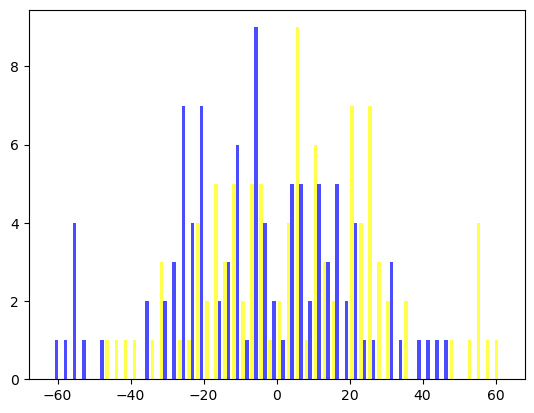

In [399]:
# Game Results, 50 bins

# create histogram
plt.hist(game_results[['margin_home_team', 'margin_away_team']], bins=50, color =['yellow', 'blue'], alpha = 0.7)

# display histogram
plt.show()

In [400]:
game_results_match

,team,margin,result
0,Northern Illinois,25.0,1.0
1,Ball State,-32.0,-1.0
2,Akron,-31.0,-1.0
3,Ohio,24.0,1.0
4,Nicholls,25.0,1.0
...,...,...,...
129,Central Arkansas,20.0,1.0
130,Midwestern State,5.0,1.0
131,Texas-Permian Basin,-37.0,-1.0
132,South Alabama,-14.0,-1.0


In [401]:
game_results_match.to_excel('game_results_match.xlsx')

### 2.4 Shapefile - Counties in the US

Load a file from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Counties+%28and+equivalent%29 that contains the shapes for all US counties in 2016. The file furthermore contains STATEFP and COUNTYFP, from which an identifier can be constructed that maps to the election outcomes.

In [402]:
gdf = gpd.read_file('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/02_Data/County_Level/tl_2016_us_county.shp')

This contains everything also Alaska and Hawaii.

<Axes: >

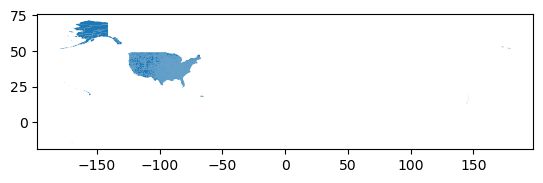

In [403]:
gdf.plot()

Filter for collected states (to begin with):

In [404]:
gdf_selection = gdf[(gdf['STATEFP'] == '48') | (gdf['STATEFP'] == '37') | (gdf['STATEFP'] == '12') | (gdf['STATEFP'] == '01') | (gdf['STATEFP'] == '22') | (gdf['STATEFP'] == '28') | (gdf['STATEFP'] == '13') | (gdf['STATEFP'] == '45')]

<Axes: >

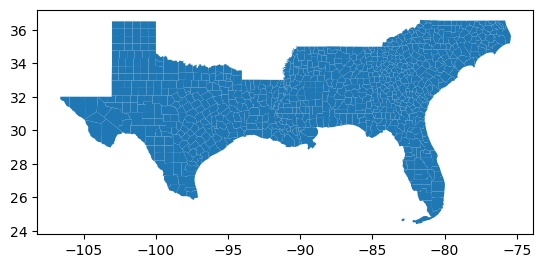

In [405]:
gdf_selection.plot()

In [406]:
gdf_selection['state_county'] = np.nan

C:\Users\jgu\AppData\Local\anaconda3\envs\Network_env\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [407]:
gdf_selection['state_county'][gdf_selection['STATEFP'] == '48'] = 'TEXAS'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '37'] = 'NORTH CAROLINA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '12'] = 'FLORIDA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '22'] = 'LOUISIANA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '01'] = 'ALABAMA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '28'] = 'MISSISSIPPI'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '13'] = 'GEORGIA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '13'] = 'GEORGIA'+gdf_selection['NAME'].str.upper()
gdf_selection['state_county'][gdf_selection['STATEFP'] == '45'] = 'SOUTH CAROLINA'+gdf_selection['NAME'].str.upper()

C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\3945890757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_selection['state_county'][gdf_selection['STATEFP'] == '48'] = 'TEXAS'+gdf_selection['NAME'].str.upper()
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\3945890757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_selection['state_county'][gdf_selection['STATEFP'] == '48'] = 'TEXAS'+gdf_selection['NAME'].str.upper()
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\3945890757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

In [408]:
gdf_selection

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state_county
7,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,NaN,NaN,NaN,A,2336237920,613559,+30.8843921,-099.8539616,"POLYGON ((-99.82187 31.08721, -99.81877 31.087...",TEXASMENARD
11,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,NaN,38380,NaN,A,2602115387,246678,+34.0684364,-101.8228879,"POLYGON ((-102.08763 34.02656, -102.08779 34.0...",TEXASHALE
12,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,NaN,NaN,NaN,A,1564252455,5284573,+33.2703999,-085.8635254,"POLYGON ((-85.97880 33.32749, -85.97854 33.332...",ALABAMACLAY
13,48,011,01383791,48011,Armstrong,Armstrong County,06,H1,G4020,108,11100,NaN,A,2354581675,12219587,+34.9641790,-101.3566363,"POLYGON ((-101.62501 35.01509, -101.62492 35.0...",TEXASARMSTRONG
15,13,189,00348794,13189,McDuffie,McDuffie County,06,H1,G4020,NaN,12260,NaN,A,666816637,23116292,+33.4824637,-082.4731880,"POLYGON ((-82.44998 33.34051, -82.45000 33.340...",GEORGIAMCDUFFIE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,22,041,00558557,22041,Franklin,Franklin Parish,15,H1,G4020,NaN,NaN,NaN,A,1617667694,28107882,+32.1390764,-091.6723711,"POLYGON ((-91.80060 32.22356, -91.80028 32.223...",LOUISIANAFRANKLIN
3216,28,155,00695798,28155,Webster,Webster County,06,H1,G4020,NaN,NaN,NaN,A,1090223315,5935288,+33.6120482,-089.2838356,"POLYGON ((-89.22905 33.72189, -89.22530 33.721...",MISSISSIPPIWEBSTER
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,NaN,NaN,NaN,A,1103983377,12186837,+34.6904951,-084.4546507,"POLYGON ((-84.65478 34.66559, -84.65488 34.669...",GEORGIAGILMER
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,NaN,A,1850058790,71143948,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707...",MISSISSIPPIMADISON


<Axes: >

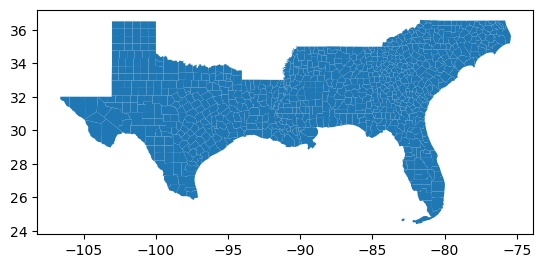

In [409]:
gdf_selection.plot()

## 03 - Merge

### 3.1 Football Prominence & Game Results

In [410]:
county_football = NCAA_fanbase.merge(game_results_match, left_on='Team', right_on='team', how='left')

In [411]:
county_football.to_excel('check.xlsx')

In [412]:
county_football['result'] = county_football['result'].fillna(0)

In [413]:
county_football['county_result'] = county_football['Percent']*county_football['result']

In [414]:
county_football['result'][county_football['total'] < 0] = np.nan
county_football['margin'][county_football['total'] < 0] = np.nan

C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1843698533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_football['result'][county_football['total'] < 0] = np.nan
C:\Users\jgu\AppData\Local\Temp\ipykernel_3276\1843698533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_football['margin'][county_football['total'] < 0] = np.nan


In [415]:
county_football

,State,County,Total,Team,Number,%,state_county,total,Percent,team,margin,result,county_result
0,Florida,Alachua,9689,Florida,8311.0,0.858,FloridaAlachua,9779.0,0.849882,Florida,-21.0,-1.0,-0.849882
1,Florida,Alachua,9689,Florida State,572.0,0.059,FloridaAlachua,9779.0,0.058493,Florida State,4.0,1.0,0.058493
2,Florida,Alachua,9689,Alabama,318.0,0.033,FloridaAlachua,9779.0,0.032519,Alabama,10.0,1.0,0.032519
3,Florida,Alachua,9689,UCF,313.0,0.032,FloridaAlachua,9779.0,0.032007,UCF,31.0,1.0,0.032007
4,Florida,Alachua,9689,Georgia,265.0,0.027,FloridaAlachua,9779.0,0.027099,Georgia,3.0,1.0,0.027099
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,South Carolina,Beaufort,2420,South Carolina,938.0,0.388,South CarolinaBeaufort,2036.0,0.460707,South Carolina,10.0,1.0,0.460707
4191,South Carolina,Beaufort,2420,Clemson,571.0,0.236,South CarolinaBeaufort,2036.0,0.280452,Clemson,54.0,1.0,0.280452
4192,South Carolina,Beaufort,2420,Georgia,241.0,0.100,South CarolinaBeaufort,2036.0,0.118369,Georgia,3.0,1.0,0.118369
4193,South Carolina,Beaufort,2420,Alabama,166.0,0.069,South CarolinaBeaufort,2036.0,0.081532,Alabama,10.0,1.0,0.081532


In [417]:
county_football.to_excel('county_football.xlsx')

In [418]:
# Prepare frame to be merged considering that within one county there are several fanbases
county_football_merge_sums = county_football.groupby('state_county')['county_result'].sum().reset_index()

In [419]:
county_football_merge_sums

,state_county,county_result
0,AlabamaAutauga,0.952222
1,AlabamaBaldwin,0.616143
2,AlabamaBarbour,0.858663
3,AlabamaBibb,0.808612
4,AlabamaBlount,0.874730
...,...,...
836,TexasWood,-0.162500
837,TexasYoakum,-0.456522
838,TexasYoung,0.006993
839,TexasZapata,-0.028571


In [420]:
county_football_merge_sums.to_excel('county_football.xlsx')

In [421]:
county_football_analysis = county_football.sort_values(['state_county', "Percent"], ascending=[True, False]).groupby('state_county').first().reset_index()

In [422]:
del county_football_analysis['county_result']

In [423]:
# Merge this back to the original frame after collapsing the original one and only keeping the most successfull team
county_football_analysis = county_football_analysis.merge(county_football_merge_sums, on='state_county', how='left')

In [424]:
county_football_analysis

,state_county,State,County,Total,Team,Number,%,total,Percent,team,margin,result,county_result
0,AlabamaAutauga,Alabama,Autauga,1493,Alabama,909.0,0.609,1800.0,0.505000,Alabama,10.0,1.0,0.952222
1,AlabamaBaldwin,Alabama,Baldwin,5591,Alabama,3327.0,0.595,5885.0,0.565336,Alabama,10.0,1.0,0.616143
2,AlabamaBarbour,Alabama,Barbour,500,Alabama,296.0,0.592,658.0,0.449848,Alabama,10.0,1.0,0.858663
3,AlabamaBibb,Alabama,Bibb,346,Alabama,245.0,0.708,418.0,0.586124,Alabama,10.0,1.0,0.808612
4,AlabamaBlount,Alabama,Blount,796,Alabama,518.0,0.651,926.0,0.559395,Alabama,10.0,1.0,0.874730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,TexasWood,Texas,Wood,214,Texas A&M,50.0,0.234,160.0,0.312500,Texas A&M,-7.0,-1.0,-0.162500
837,TexasYoakum,Texas,Yoakum,84,Texas Tech,52.0,0.619,92.0,0.565217,Texas Tech,-8.0,-1.0,-0.456522
838,TexasYoung,Texas,Young,153,Texas Tech,46.0,0.301,143.0,0.321678,Texas Tech,-8.0,-1.0,0.006993
839,TexasZapata,Texas,Zapata,40,Texas A&M,14.0,0.350,35.0,0.400000,Texas A&M,-7.0,-1.0,-0.028571


In [425]:
county_football_analysis.to_excel('check.xlsx')

In [426]:
# Convert matching Ids to upper case
county_football_analysis['state_county'] = county_football_analysis['state_county'].str.upper()

In [427]:
county_football_analysis

,state_county,State,County,Total,Team,Number,%,total,Percent,team,margin,result,county_result
0,ALABAMAAUTAUGA,Alabama,Autauga,1493,Alabama,909.0,0.609,1800.0,0.505000,Alabama,10.0,1.0,0.952222
1,ALABAMABALDWIN,Alabama,Baldwin,5591,Alabama,3327.0,0.595,5885.0,0.565336,Alabama,10.0,1.0,0.616143
2,ALABAMABARBOUR,Alabama,Barbour,500,Alabama,296.0,0.592,658.0,0.449848,Alabama,10.0,1.0,0.858663
3,ALABAMABIBB,Alabama,Bibb,346,Alabama,245.0,0.708,418.0,0.586124,Alabama,10.0,1.0,0.808612
4,ALABAMABLOUNT,Alabama,Blount,796,Alabama,518.0,0.651,926.0,0.559395,Alabama,10.0,1.0,0.874730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,TEXASWOOD,Texas,Wood,214,Texas A&M,50.0,0.234,160.0,0.312500,Texas A&M,-7.0,-1.0,-0.162500
837,TEXASYOAKUM,Texas,Yoakum,84,Texas Tech,52.0,0.619,92.0,0.565217,Texas Tech,-8.0,-1.0,-0.456522
838,TEXASYOUNG,Texas,Young,153,Texas Tech,46.0,0.301,143.0,0.321678,Texas Tech,-8.0,-1.0,0.006993
839,TEXASZAPATA,Texas,Zapata,40,Texas A&M,14.0,0.350,35.0,0.400000,Texas A&M,-7.0,-1.0,-0.028571


In [428]:
map_football = gdf_selection.merge(county_football_analysis, on='state_county', how='left')

In [429]:
#del map_football['geometry']

In [430]:
#map_football.to_excel('map_football.xlsx')

<Axes: >

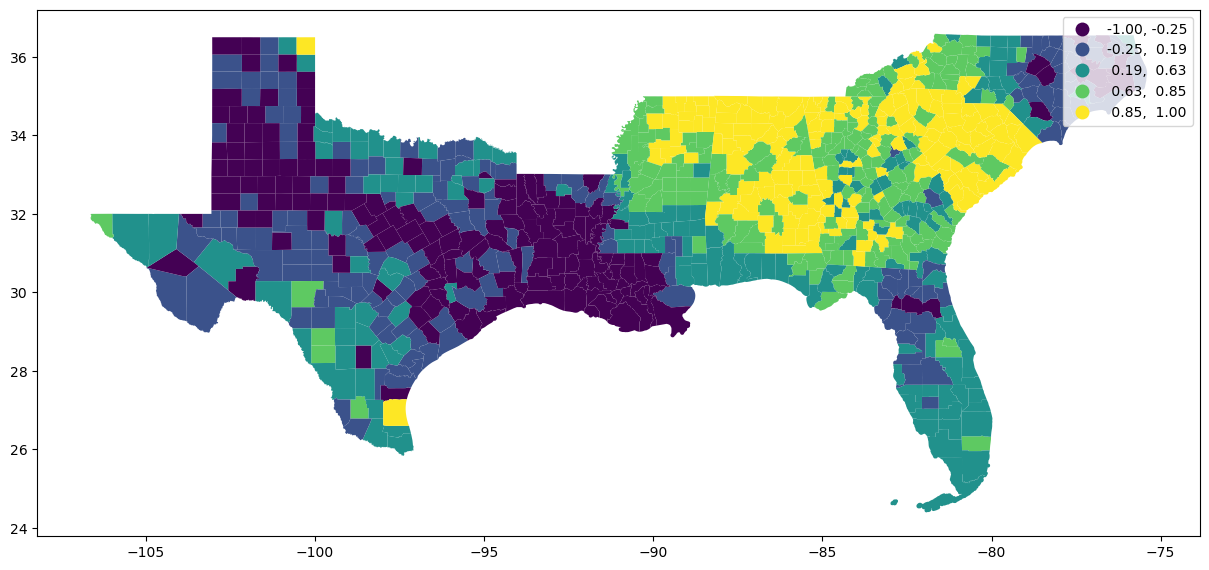

In [431]:
map_football.plot(column="county_result",
                  legend=True,
                  scheme="quantiles",
                  figsize=(15, 10),
                  missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})

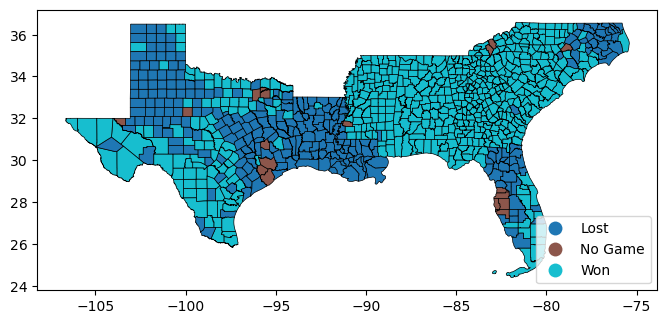

In [448]:
map_football.plot(column="result",
                  categorical=True,
                  legend=True,
                  #scheme="quantiles",
                  figsize=(8, 6),
                  legend_kwds={'loc': 'lower right', 'labels': ['Lost', 'No Game', 'Won']},
                  missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
                  edgecolor='black',
                  linewidth=0.5)
plt.savefig('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/04_Output/spatial_variation.png', bbox_inches='tight', dpi=300, transparent=True, pad_inches=0)

In [449]:
map_football['min_dist_other'] = np.nan
map_football = map_football.to_crs(crs=3857)

In [450]:
map_football['centroid'] = map_football['geometry'].centroid

In [451]:
map_football['centroid']

0      POINT (-11111985.276 3618466.838)
1      POINT (-11335316.591 4038320.715)
2       POINT (-9557945.322 3931101.770)
3      POINT (-11283054.396 4159154.809)
4       POINT (-9181789.043 3959590.881)
                     ...                
834    POINT (-10205071.427 3780849.271)
835     POINT (-9939137.849 3976975.192)
836     POINT (-9401558.047 4122008.391)
837    POINT (-10022494.938 3846941.510)
838    POINT (-11291748.476 3803602.335)
Name: centroid, Length: 839, dtype: geometry

In [452]:
map_football

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Number,%,total,Percent,team,margin,result,county_result,min_dist_other,centroid
0,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,NaN,...,3.0,0.500,6.0,0.500000,UTSA,20.0,1.0,2.775558e-17,NaN,POINT (-11111985.276 3618466.838)
1,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,NaN,...,156.0,0.549,268.0,0.582090,Texas Tech,-8.0,-1.0,-3.283582e-01,NaN,POINT (-11335316.591 4038320.715)
2,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,NaN,...,68.0,0.469,172.0,0.395349,Auburn,7.0,1.0,8.837209e-01,NaN,POINT (-9557945.322 3931101.770)
3,48,011,01383791,48011,Armstrong,Armstrong County,06,H1,G4020,108,...,5.0,0.714,10.0,0.500000,Texas Tech,-8.0,-1.0,-7.000000e-01,NaN,POINT (-11283054.396 4159154.809)
4,13,189,00348794,13189,McDuffie,McDuffie County,06,H1,G4020,NaN,...,252.0,0.712,393.0,0.641221,Georgia,3.0,1.0,6.793893e-01,NaN,POINT (-9181789.043 3959590.881)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,22,041,00558557,22041,Franklin,Franklin Parish,15,H1,G4020,NaN,...,200.0,0.760,278.0,0.719424,LSU,-10.0,-1.0,-5.000000e-01,NaN,POINT (-10205071.427 3780849.271)
835,28,155,00695798,28155,Webster,Webster County,06,H1,G4020,NaN,...,139.0,0.803,231.0,0.601732,Mississippi State,7.0,1.0,9.134199e-01,NaN,POINT (-9939137.849 3976975.192)
836,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,NaN,...,243.0,0.757,304.0,0.799342,Georgia,3.0,1.0,9.013158e-01,NaN,POINT (-9401558.047 4122008.391)
837,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,1857.0,0.554,4260.0,0.435915,Mississippi State,7.0,1.0,6.882629e-01,NaN,POINT (-10022494.938 3846941.510)


Run a loop that calculates the shortest distance between a centroid of a county that won and the centroid of a county that lost and vice versa.

In [453]:
for index, row in map_football.iterrows():


    point = row['centroid']
    #print(point)

    result = row['result']
    #print(result)

    if result == 0:
        map_football.at[index, 'min_dist_other'] = np.nan

    elif pd.isnull(result):
        map_football.at[index, 'min_dist_other'] = np.nan

    else:
        df_calc = map_football[(map_football['result'] != result) & (map_football['result'] != 0) & (map_football['result'] != np.nan) & (~map_football['result'].isnull())]

        # Now calculate shortest distance to other communities and store the shortest
        #df_calc['min_dist'] = np.nan
        a = df_calc['centroid'].distance(point).min()
        map_football.at[index, 'min_dist_other'] = a

Normalize and create distance to border.

In [454]:
map_football['norm_dist'] = map_football['min_dist_other']/map_football['min_dist_other'].max()

In [455]:
map_football['norm_dist_cutoff'] = map_football['norm_dist']*map_football['result']

### 3.2 Match Election Outcomes

In [569]:
raw_elections

party,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican
0,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178
1,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901
2,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527
3,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915
4,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921
...,...,...,...,...,...,...,...,...,...,...,...,...
15769,2016,WYOMING,56037.0,SWEETWATER,US PRESIDENT,20220315,17130,3231,12154,15385,0.210010,0.789990
15770,2016,WYOMING,56039.0,TETON,US PRESIDENT,20220315,12627,7314,3921,11235,0.651001,0.348999
15771,2016,WYOMING,56041.0,UINTA,US PRESIDENT,20220315,8470,1202,6154,7356,0.163404,0.836596
15772,2016,WYOMING,56043.0,WASHAKIE,US PRESIDENT,20220315,3814,532,2911,3443,0.154516,0.845484


In [570]:
raw_elections['state_county'] = raw_elections['state'] + raw_elections['county_name']

In [571]:
raw_elections

party,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican,state_county
0,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178,ALABAMAAUTAUGA
1,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901,ALABAMABALDWIN
2,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527,ALABAMABARBOUR
3,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915,ALABAMABIBB
4,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921,ALABAMABLOUNT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,2016,WYOMING,56037.0,SWEETWATER,US PRESIDENT,20220315,17130,3231,12154,15385,0.210010,0.789990,WYOMINGSWEETWATER
15770,2016,WYOMING,56039.0,TETON,US PRESIDENT,20220315,12627,7314,3921,11235,0.651001,0.348999,WYOMINGTETON
15771,2016,WYOMING,56041.0,UINTA,US PRESIDENT,20220315,8470,1202,6154,7356,0.163404,0.836596,WYOMINGUINTA
15772,2016,WYOMING,56043.0,WASHAKIE,US PRESIDENT,20220315,3814,532,2911,3443,0.154516,0.845484,WYOMINGWASHAKIE


In [572]:
raw_elections = raw_elections.set_index(['state_county', 'year'])

In [573]:
raw_elections['lag']=raw_elections.groupby(level=0)['margin_democrat'].shift(1)

In [574]:
raw_elections = raw_elections.reset_index()

In [575]:
raw_elections['change']=raw_elections['margin_democrat']-raw_elections['lag']

In [576]:
raw_elections

party,state_county,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican,lag,change
0,ALABAMAAUTAUGA,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178,NaN,NaN
1,ALABAMABALDWIN,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901,NaN,NaN
2,ALABAMABARBOUR,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527,NaN,NaN
3,ALABAMABIBB,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915,NaN,NaN
4,ALABAMABLOUNT,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,WYOMINGSWEETWATER,2016,WYOMING,56037.0,SWEETWATER,US PRESIDENT,20220315,17130,3231,12154,15385,0.210010,0.789990,0.294655,-0.084645
15770,WYOMINGTETON,2016,WYOMING,56039.0,TETON,US PRESIDENT,20220315,12627,7314,3921,11235,0.651001,0.348999,0.561196,0.089805
15771,WYOMINGUINTA,2016,WYOMING,56041.0,UINTA,US PRESIDENT,20220315,8470,1202,6154,7356,0.163404,0.836596,0.197501,-0.034097
15772,WYOMINGWASHAKIE,2016,WYOMING,56043.0,WASHAKIE,US PRESIDENT,20220315,3814,532,2911,3443,0.154516,0.845484,0.208508,-0.053992


In [577]:
raw_elections.to_stata('election.dta') # Export to Stata

In [578]:
raw_elections = raw_elections[(raw_elections['state'] == 'FLORIDA') | (raw_elections['state'] == 'TEXAS') | (raw_elections['state'] == 'NORTH CAROLINA') | (raw_elections['state'] == 'ALABAMA') | (raw_elections['state'] == 'LOUISIANA') | (raw_elections['state'] == 'MISSISSIPPI') | (raw_elections['state'] == 'GEORGIA') | (raw_elections['state'] == 'SOUTH CAROLINA')]

In [579]:
raw_elections

party,state_county,year,state,county_fips,county_name,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total,margin_democrat,margin_republican,lag,change
0,ALABAMAAUTAUGA,2000,ALABAMA,1001.0,AUTAUGA,US PRESIDENT,20220315,17208,4942,11993,16935,0.291822,0.708178,NaN,NaN
1,ALABAMABALDWIN,2000,ALABAMA,1003.0,BALDWIN,US PRESIDENT,20220315,56480,13997,40872,54869,0.255099,0.744901,NaN,NaN
2,ALABAMABARBOUR,2000,ALABAMA,1005.0,BARBOUR,US PRESIDENT,20220315,10395,5188,5096,10284,0.504473,0.495527,NaN,NaN
3,ALABAMABIBB,2000,ALABAMA,1007.0,BIBB,US PRESIDENT,20220315,7101,2710,4273,6983,0.388085,0.611915,NaN,NaN
4,ALABAMABLOUNT,2000,ALABAMA,1009.0,BLOUNT,US PRESIDENT,20220315,17973,4977,12667,17644,0.282079,0.717921,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15403,TEXASWOOD,2016,TEXAS,48499.0,WOOD,US PRESIDENT,20220315,18727,2630,15700,18330,0.143481,0.856519,0.175562,-0.032081
15404,TEXASYOAKUM,2016,TEXAS,48501.0,YOAKUM,US PRESIDENT,20220315,2303,426,1797,2223,0.191633,0.808367,0.194115,-0.002482
15405,TEXASYOUNG,2016,TEXAS,48503.0,YOUNG,US PRESIDENT,20220315,7707,876,6601,7477,0.117159,0.882841,0.137453,-0.020294
15406,TEXASZAPATA,2016,TEXAS,48505.0,ZAPATA,US PRESIDENT,20220315,3142,2063,1029,3092,0.667206,0.332794,0.717083,-0.049877


In [580]:
raw_elections = raw_elections[raw_elections['year'] == 2016]

In [581]:
raw_elections = map_football.merge(raw_elections, on='state_county', how='left')

In [582]:
raw_elections

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,office,version,totalvotes,DEMOCRAT,REPUBLICAN,Total_y,margin_democrat,margin_republican,lag,change
0,48,327,01383949,48327,Menard,Menard County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,864,154,682,836,0.184211,0.815789,0.204545,-0.020335
1,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,8858,2101,6366,8467,0.248140,0.751860,0.256842,-0.008702
2,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,6624,1237,5245,6482,0.190836,0.809164,0.269487,-0.078651
3,48,011,01383791,48011,Armstrong,Armstrong County,06,H1,G4020,108,...,US PRESIDENT,20220315,1021,70,924,994,0.070423,0.929577,0.105832,-0.035409
4,13,189,00348794,13189,McDuffie,McDuffie County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,9268,3699,5432,9131,0.405103,0.594897,0.424835,-0.019731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,22,041,00558557,22041,Franklin,Franklin Parish,15,H1,G4020,NaN,...,US PRESIDENT,20220315,9162,2506,6514,9020,0.277827,0.722173,0.316983,-0.039156
835,28,155,00695798,28155,Webster,Webster County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,5069,1019,3976,4995,0.204004,0.795996,0.229641,-0.025637
836,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,NaN,...,US PRESIDENT,20220315,12773,1965,10477,12442,0.157933,0.842067,0.179897,-0.021964
837,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,US PRESIDENT,20220315,49802,20343,28265,48608,0.418511,0.581489,0.420931,-0.002419


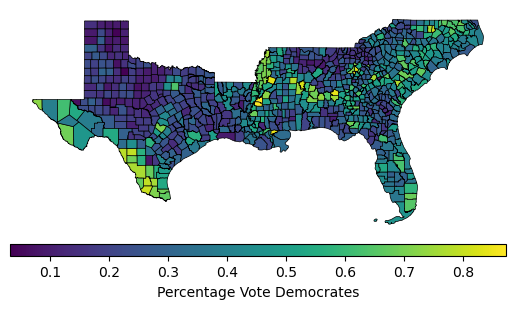

In [583]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)

cax = divider.append_axes("bottom", size="5%", pad=0.1)

raw_elections.plot(column="margin_democrat",
                   ax=ax,
                   cax=cax,
                   legend=True,
                   #scheme="quantiles",
                   figsize=(10, 7.5),
                   missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
                   legend_kwds={"label": "Percentage Vote Democrates", "orientation": "horizontal"},
                   edgecolor='black',
                   linewidth=0.5)
ax.set_axis_off()
plt.savefig('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/04_Output/election_variation.png', bbox_inches='tight', dpi=300, transparent=True, pad_inches=0)

In [584]:
raw_elections.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'state_county', 'State',
       'County', 'Total_x', 'Team', 'Number', '%', 'total', 'Percent', 'team',
       'margin', 'result', 'county_result', 'min_dist_other', 'centroid',
       'norm_dist', 'norm_dist_cutoff', 'year', 'state', 'county_fips',
       'county_name', 'office', 'version', 'totalvotes', 'DEMOCRAT',
       'REPUBLICAN', 'Total_y', 'margin_democrat', 'margin_republican', 'lag',
       'change'],
      dtype='object')

In [585]:
del raw_elections['geometry']
#del raw_elections['GEOID']

In [592]:
raw_elections[['margin_democrat', 'norm_dist', 'norm_dist_cutoff', 'State', 'lag', 'change']].to_stata('election.dta') # Export to Stata

In [ ]:
regression_output = pd.read_stata('C:/Users/jgu/Dropbox/01_Studium/03_Univ_Mannheim/06_PhD/06_GESS/12_New_Perspectives_in_Economics_and_Politics/02_Data/regression_output_one.dta')

In [ ]:
regression_output

In [ ]:
regression_output = regression_output[regression_output['year'] == 2016]

In [ ]:
map_football

In [ ]:
regression_output

In [ ]:
regression_two = map_football.merge(regression_output, on='state_county', how='left')

In [ ]:
regression_two.plot(column="change",
                  legend=True,
                  #scheme="quantiles",
                  figsize=(15, 10),
                  missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"})


#regression_two = regression_two.to_crs(crs=4326)


In [ ]:
del regression_two['geometry']
regression_two[['state_county', 'norm_dist_cutoff', 'margin_democrat', 'e', 'state', 'county_result', 'result', 'change']].to_stata('regression_two.dta')

In [ ]:
regression_two